In [1]:
import os
import json
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

from google.cloud import bigquery
from google.oauth2 import service_account

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)

#pd.set_option('display.max_rows',None)     # 모든 행 보기
#pd.reset_option('display.max_rows')        # 기본값으로 되돌리기

In [2]:
df = pd.read_csv('ga4_data.csv')

/var/folders/mk/p5y6cznx60788rys6_dnljxm0000gn/T/ipykernel_17178/4055328101.py:1: DtypeWarning: Columns (1,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ga4_data.csv')


In [3]:
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'])
df['totals_totalTransactionRevenue'] = df['totals_totalTransactionRevenue'].fillna(0)
#df['hits_eCommerceAction_action_type'] = df['hits_eCommerceAction_action_type'].fillna(0)
df['hits_transaction_transactionRevenue'] = df['hits_transaction_transactionRevenue'].fillna(0)
#df.loc[(df.trafficSource_medium == 'organic') & (df.trafficSource_keyword.isnull()), 'trafficSource_keyword'] = '(not provided)'
#df.loc[(df.trafficSource_medium.isin(["(none)", 'affiliate'])) & (df.trafficSource_keyword.isnull()), 'trafficSource_keyword'] = '(not set)'

df.visitStartTime = (df.visitStartTime - timedelta(hours=8))
df = df.assign(month = df.visitStartTime.dt.strftime('%Y-%m'))
df = df.assign(date = df.visitStartTime.dt.strftime('%m-%d'))
df = df.assign(day_name = df.visitStartTime.dt.weekday)

#문자열로 치환
df['fullVisitorId'] = df['fullVisitorId'].astype(str)

def pad_with_zeros(string):
    """
    문자열의 길이가 19이 될 때까지 앞에 0을 추가하는 함수
    """
    # 문자열의 길이를 세기
    length = len(string)
    
    # 문자열의 길이가 20이 될 때까지 앞에 0을 추가
    while length < 19:
        string = '0' + string
        length += 1
    
    return string

df['fullVisitorId'] = df['fullVisitorId'].apply(pad_with_zeros)

In [24]:
df.to_csv('ID전처리된데이터.csv', index=False)

# 시간별 구매건수, 요일별 매출합계

In [4]:
# 비구매
df_not_sales = df[df.hits_transaction_transactionRevenue == 0]

# 구매
df_sales = df[df.hits_transaction_transactionRevenue !=0]
df_sales.head(5)

,channelGrouping,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,totals_sessionQualityDim,totals_newVisits,totals_totalTransactionRevenue,totals_bounces,trafficSource_referralPath,trafficSource_campaign,trafficSource_medium,trafficSource_keyword,trafficSource_adContent,trafficSource_isTrueDirect,trafficSource_adwordsClickInfo_page,trafficSource_adwordsClickInfo_slot,hits_hitNumber,hits_hour,hits_minute,hits_eventInfo_eventCategory,hits_eventInfo_eventAction,hits_eventInfo_eventLabel,hits_eventInfo_eventValue,hits_type,hits_referer,hits_isExit,hits_page_pageTitle,hits_page_searchKeyword,hits_transaction_transactionRevenue,hits_transaction_transactionTax,hits_transaction_transactionShipping,hits_eCommerceAction_action_type,hits_eCommerceAction_step,hits_social_socialNetwork,hits_social_hasSocialSourceReferral,month,date,day_name
516,Paid Search,7071796515432628889,1481317989,1,2016-12-09 13:13:09,Chrome,NaN,1.0,18.99,NaN,NaN,(not set),(none),NaN,NaN,NaN,1.0,Top,15,13,33,NaN,NaN,NaN,NaN,PAGE,NaN,NaN,Checkout Confirmation,NaN,18.99,NaN,8.50,6,1,(not set),No,2016-12,12-09,4
709,Referral,7344052172589114599,1481325142,4,2016-12-09 15:12:22,Chrome,NaN,NaN,63.99,NaN,/,(not set),(none),NaN,NaN,True,NaN,NaN,27,15,22,NaN,NaN,NaN,NaN,PAGE,NaN,NaN,Checkout Confirmation,NaN,63.99,11.59,14.50,6,1,(not set),No,2016-12,12-09,4
760,Referral,9113941842423951510,1481323435,3,2016-12-09 14:43:55,Chrome,NaN,NaN,187.77,NaN,/mail/u/0/,(not set),referral,NaN,NaN,NaN,NaN,NaN,25,14,58,NaN,NaN,NaN,NaN,PAGE,NaN,NaN,Checkout Confirmation,NaN,64.59,7.71,16.78,6,1,(not set),No,2016-12,12-09,4
763,Organic Search,8670467728578251460,1481325665,2,2016-12-09 15:21:05,Chrome,NaN,NaN,45.95,NaN,NaN,(not set),(none),NaN,NaN,NaN,NaN,NaN,34,15,32,NaN,NaN,NaN,NaN,PAGE,NaN,NaN,Checkout Confirmation,NaN,45.95,8.57,11.50,6,1,(not set),No,2016-12,12-09,4
852,Referral,4033655615670436076,1481320622,5,2016-12-09 13:57:02,Chrome,NaN,NaN,58.58,NaN,/,(not set),(none),NaN,NaN,True,NaN,NaN,45,14,20,NaN,NaN,NaN,NaN,PAGE,NaN,NaN,Checkout Confirmation,NaN,58.58,10.38,18.78,6,1,(not set),No,2016-12,12-09,4


<Axes: xlabel='hits_hour'>

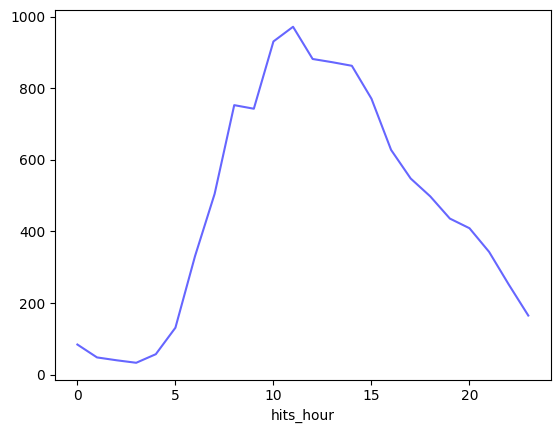

In [5]:
df_sales.hits_hour.value_counts().sort_index().plot(color='blue', alpha=0.6)

In [6]:
temp = df_sales.hits_hour.value_counts().sort_index()
temp.to_csv('hit_hour.csv', index=False)

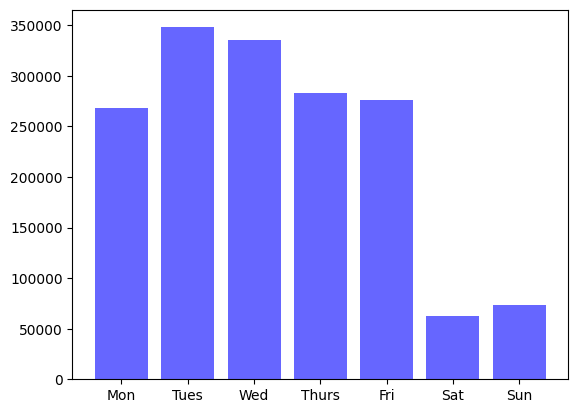

In [7]:
df_sales_dayname = df_sales.groupby('day_name')['hits_transaction_transactionRevenue'].sum().reset_index(name='sum_sales')

weekdays =['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
plt.xticks(df_sales_dayname.day_name, weekdays)
plt.bar(df_sales_dayname.day_name, df_sales_dayname.sum_sales,color='blue', alpha=0.6)
plt.show()

In [8]:
df_sales_dayname.to_csv('sales_by_day.csv', index=False)

# 고객 당 매출 비율
- 고객의 25%가 매출 80%를 차지함

In [11]:
visit_cnt = df.groupby('fullVisitorId').visitNumber.nunique().reset_index(name = 'visit_cnt')

# 구매유저
df_sales_cnt = df_sales.groupby('fullVisitorId')['hits_transaction_transactionRevenue'].agg(['count', 'sum']).rename(columns={"count":"sales_count", "sum":"sales_sum"}).sort_values('sales_sum', ascending=False).reset_index()
df_sales_cnt = df_sales_cnt.assign(sum_cumsum = df_sales_cnt.sales_sum.cumsum())
df_sales_cnt = df_sales_cnt.assign(sales_per_once = ((df_sales_cnt.sales_sum) / (df_sales_cnt.sales_count)).round(2))
df_sales_cnt = pd.merge(df_sales_cnt, visit_cnt, how='left', on='fullVisitorId')
df_sales_cnt = df_sales_cnt.assign(proportion = df_sales_cnt.sum_cumsum / 1645876.88*100)

In [12]:
import pandas as pd

# 먼저 아래 가설이 맞는지 대충 확인 먼저 하기.
# 그전에 먼저 2 -> 3번 넘어가는 구매자 리스트로 코드 다시 팀에게 주기

# 트랜잭션이 0 이 아닌 날로 (day) 로 묶어서 새로운 revenue_day 를 만들기 
# fullVisitorId 당 revenue_day 를 sort_value 하기 - ascending=False
# fullVisitorId 당 revenue_day 의 diff 를 계산하기
# fullVisitorId 당 revenue_day_diff 의 평균을 계산
# fullVisitorId 당 양수의 diff 평균 값이 나오는지 확인 

# sorted_purchase = purchase_dates.groupby('fullVisitorId').apply(lambda x: x.sort_values('visitStartTime', ascending=False))

# purchase_intervals_days = (sorted_purchase.groupby('fullVisitorId')['visitStartTime'].diff() / pd.Timedelta(days=1))

# purchase_intervals_days.groupby('fullVisitorId')['visitStartTime'].sum()

# average_interval_days = purchase_intervals_days.groupby(level=0).mean()

# average_interval_days.fillna(0, inplace=True)

# average_interval_days

In [13]:
df_sales_cnt = df_sales_cnt.sort_values(by='sales_count', ascending=False)
df_sales_cnt[df_sales_cnt['sales_count'] >= 12]
# 고객별 재구매 기간의 평균 (R), sales_count (F),  sales_sum (M) 으로 고객을 분류.

,fullVisitorId,sales_count,sales_sum,sum_cumsum,sales_per_once,visit_cnt,proportion
56,7813149961404844386,36,2797.51,445242.19,77.71,86,27.051974
14,6760732402251466726,27,6530.48,283027.33,241.87,40,17.196142
82,5526675926038480325,25,2058.09,507802.62,82.32,1,30.853014
0,1957458976293878100,22,128446.52,128446.52,5838.48,275,7.804139
5,4984366501121503466,17,9658.40,217249.37,568.14,24,13.199612
555,8637158932301658318,15,480.00,915884.83,32.00,1,55.647226
37,2402527199731150932,15,3491.63,385626.09,232.78,29,23.429826
44,9662800125044386280,14,3239.04,409006.25,231.36,17,24.850355
41,0608915197735218105,14,3313.23,399183.36,236.66,17,24.253537
142,7713012430069756739,12,1352.63,605604.54,112.72,1,36.795252


In [ ]:
#민희님 -- 전체 매출의 80%는 ? 구매유저의 25% 를 VVIP, 또는 한번의 구매의 1%를 VVIP 로

In [14]:
# 전체 매출의 80%는 ? 구매유저의 25% 정도가 차지
print(len(df_sales_cnt[df_sales_cnt.proportion < 80]))
print(len(df_sales_cnt))
print(len(df_sales_cnt[df_sales_cnt.proportion < 80]) / len(df_sales_cnt) * 100)

2392
9421
25.390085978133957


# 월별 총 매출 및 매출건수

In [15]:
df_month = df_sales.groupby('month')['hits_transaction_transactionRevenue'].agg(['sum', 'count']).reset_index()
df_month = df_month.rename(columns={'sum': 'sales', 'count': 'cnt'})
df_month

,month,sales,cnt
0,2016-08,151284.75,1073
1,2016-09,127028.05,862
2,2016-10,118113.22,879
3,2016-11,128312.27,907
4,2016-12,156828.79,1374
5,2017-01,101419.17,687
6,2017-02,111447.17,690
7,2017-03,137851.96,888
8,2017-04,218859.22,924
9,2017-05,130128.22,1111


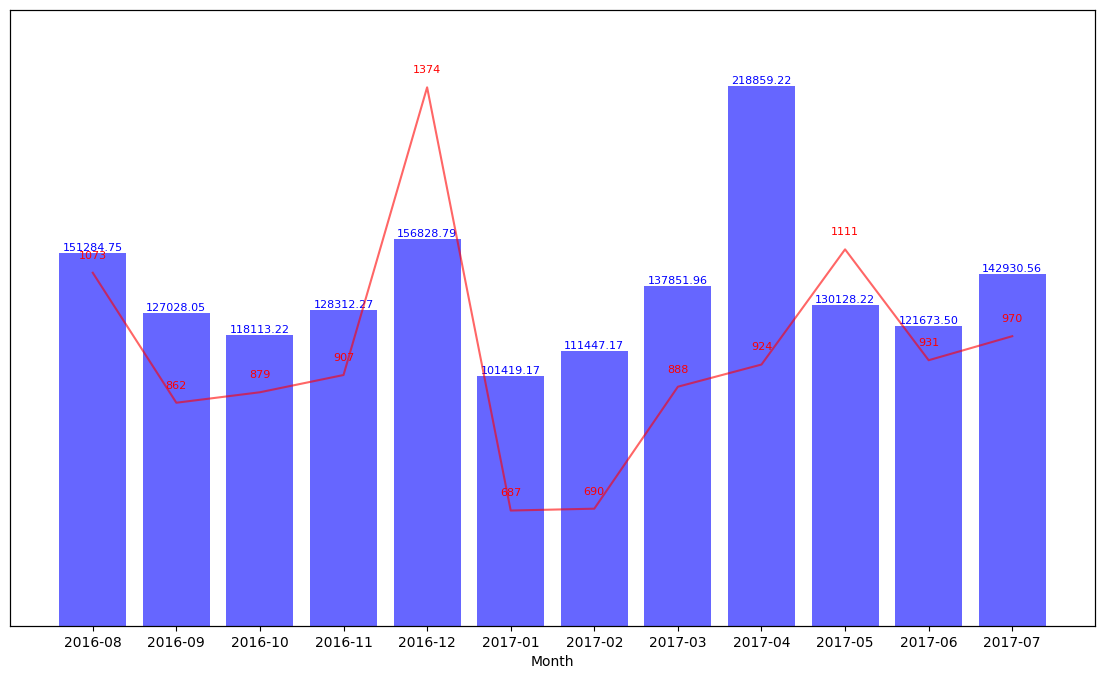

In [16]:
# 첫 번째 y 축에 대한 라인 플롯 생성
fig, ax1 = plt.subplots(figsize=(14, 8))
bar = ax1.bar(df_month.month, df_month['sales'], color='blue', alpha=0.6)
ax1.set_xlabel('Month')
# y축 조정
plt.ylim([0, 250000])
plt.gca().axes.yaxis.set_visible(False)
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height + 100, '%.2f' % height, ha='center', va='bottom', size=8, color='b')

# 두 번째 y 축에 대한 라인 플롯 생성
ax2 = ax1.twinx()  # 두 번째 y 축 생성
ax2.plot(df_month.month, df_month['cnt'], color='red', alpha=0.6)
# y축 조정
plt.ylim([500, 1500])
plt.gca().axes.yaxis.set_visible(False)
ax2.set_ylabel('Count', color='r')
for i in range(len(df_month)):
    height = df_month['cnt'][i]
    plt.text(df_month.month[i], height+20, '%.0f' % height, ha='center', va='bottom', size=8, color='r')
plt.show()

In [17]:
df_month.to_csv('sales_by_month.csv', index=False)

# Arppu

In [18]:
month_list=df.month.unique()
month_list.sort()
month_list

array(['2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07'], dtype=object)

In [19]:
# 각 월별로 매출 합계를 계산
df_arppu = df_sales.groupby(['month', 'fullVisitorId'])['hits_transaction_transactionRevenue'].sum().reset_index(name='sum_rev')

# 각 월별로 ARPPU를 계산하고 리스트에 저장
arppu_values = []
for month in month_list:
    arppu_values.append(df_arppu[df_arppu.month == month]['sum_rev'].mean())


# DataFrame 생성
data = {'month': month_list, 'arppu': arppu_values}
df_arppu = pd.DataFrame(data)

# ARPPU 값을 소수점 둘째 자리까지 반올림
df_arppu['arppu'] = df_arppu['arppu'].round(2)

df_arppu

,month,arppu
0,2016-07,NaN
1,2016-08,158.25
2,2016-09,167.36
3,2016-10,151.62
4,2016-11,156.86
5,2016-12,125.56
6,2017-01,159.21
7,2017-02,176.34
8,2017-03,182.34
9,2017-04,260.86


posx and posy should be finite values
posx and posy should be finite values


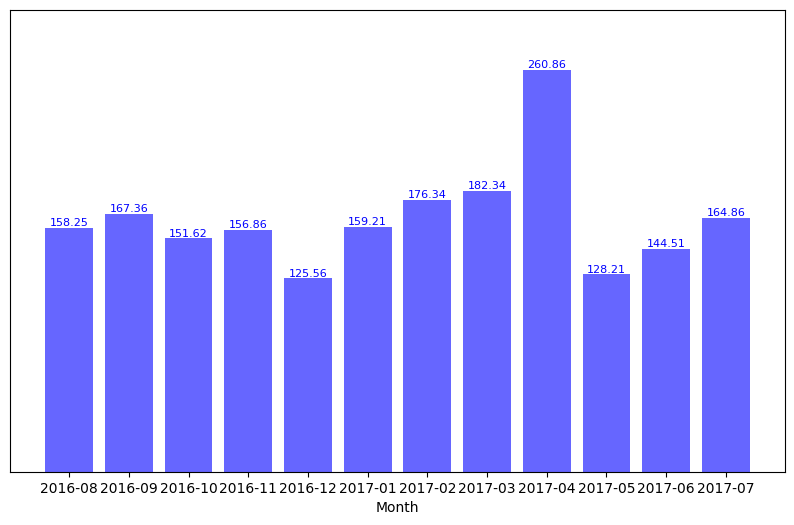

In [20]:
import matplotlib.pyplot as plt

# Create figure and axis with desired figure size
fig, ax1 = plt.subplots(figsize=(10, 6))

# Your plotting code
bar = ax1.bar(df_arppu.month, df_arppu.arppu, color='blue', alpha=0.6)
ax1.set_xlabel('Month')
ax1.set_ylim([0, 300])
ax1.yaxis.set_visible(False)  # This line replaces plt.gca().axes.yaxis.set_visible(False)

# Add labels on top of bars
for rect in bar:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2.0, height, '%.2f' % height, ha='center', va='bottom', size=8, color='b')

plt.show()


In [21]:
df_arppu.to_csv('arpu_by_month.csv', index=False)

### 군집 0

In [4]:
clustering = pd.read_csv('clustering.csv')

clustering['fullVisitorId'] = clustering['fullVisitorId'].astype(str)
clustering['fullVisitorId'] = clustering['fullVisitorId'].apply(pad_with_zeros)

# merge
label_df = df.merge(clustering, on='fullVisitorId', how='left')

In [16]:
zeros = label_df[label_df['labels'] == 0]
zero_rev = zeros['hits_transaction_transactionRevenue'].sum()

total_rev = label_df['hits_transaction_transactionRevenue'].sum()
total_rev

1645876.8800000008

In [15]:
zero_rev = zeros['totals_totalTransactionRevenue'].sum()

total_rev = label_df['totals_totalTransactionRevenue'].sum()
zero_rev / total_rev

0.6938305243276999